In [ ]:
import tensorflow as tf
import tensorflow.keras as keras 
import numpy as np

In [ ]:
vgg = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(300, 300, 3), pooling=None, classes=1000,
    classifier_activation='softmax'
)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras import preprocessing

In [ ]:
inp = keras.Input(shape=(300, 300, 3))
x = keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)(inp)
vgg_out = keras.layers.Flatten()(vgg(x))
#vgg_out = keras.layers.BatchNormalization()(vgg_out1)

watermark_hidden1 = keras.layers.Dense(64, activation="relu", name="watermark_hidden1")(vgg_out)
watermark_hidden2 = keras.layers.Dense(32, activation="relu", name="watermark_hidden2")(watermark_hidden1)
watermark_hidden3 = keras.layers.Dense(32, activation="relu", name="watermark_hidden3")(watermark_hidden2)
watermark_hidden4 = keras.layers.Dense(10, activation="relu", name="watermark_hidden4")(watermark_hidden3)
watermark_output = keras.layers.Dense(1, activation="sigmoid", name="watermark_output")(watermark_hidden4)

watermark_model = keras.Model(inputs=inp, outputs=watermark_output)

In [ ]:
watermark_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 300, 300, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 41472)             0         
_________________________________________________________________
watermark_hidden1 (Dense)    (None, 64)                2654272   
_________________________________________________________________
watermark_hidden2 (Dense)    (None, 32)                2080      
_________________________________________________________________
watermark_hidden3 (Dense)    (None, 32)                1056

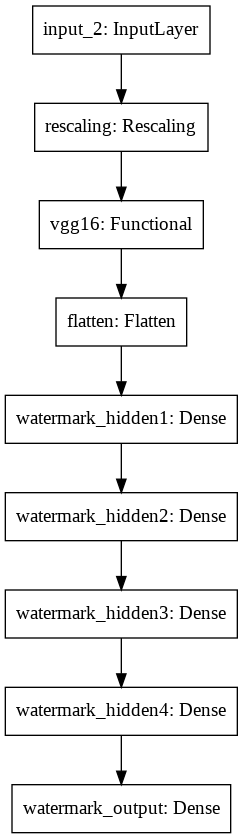

In [ ]:
keras.utils.plot_model(watermark_model)

In [ ]:
watermark_model.get_layer("vgg16").trainable = False

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
data_dir = '/gdrive/MyDrive/faces/liveliness_detection'
img_height = img_width = 300
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 2010 files belonging to 2 classes.
Using 1608 files for training.
Found 2010 files belonging to 2 classes.
Using 402 files for validation.


In [ ]:
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(logical_gpus)

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [ ]:
opt = keras.optimizers.Adam(learning_rate=1e-5)

In [ ]:
watermark_model.compile(optimizer=opt, loss='binary_crossentropy',
    metrics=["accuracy"])


In [ ]:
with tf.device('/device:GPU:0'):
    watermark_model.fit(train_ds, validation_data=val_ds, epochs=1)

26/26 [==============================] - 25s 845ms/step - loss: 0.5474 - accuracy: 0.8060 - val_loss: 0.3926 - val_accuracy: 0.9851


In [ ]:
watermark_model.evaluate(train_ds)

26/26 [==============================] - 20s 652ms/step - loss: 0.3930 - accuracy: 0.9813


[0.393005907535553, 0.9813432693481445]

In [ ]:
%cd /content
watermark_model.save("liveliness_detection")

/content
INFO:tensorflow:Assets written to: liveliness_detection/assets


In [ ]:
!zip -r liveliness_detection.zip /content/liveliness_detection

  adding: content/liveliness_detection/ (stored 0%)
  adding: content/liveliness_detection/keras_metadata.pb (deflated 96%)
  adding: content/liveliness_detection/assets/ (stored 0%)
  adding: content/liveliness_detection/saved_model.pb (deflated 91%)
  adding: content/liveliness_detection/variables/ (stored 0%)
  adding: content/liveliness_detection/variables/variables.index (deflated 68%)
  adding: content/liveliness_detection/variables/variables.data-00000-of-00001 (deflated 11%)


In [ ]:
train_ds.class_names

['lively', 'not_lively']

In [ ]:
def get_liveliness(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (300, 300))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((-1, 300, 300, 3))
    classes = ['lively', 'not_lively']

    model = keras.models.load_model("liveliness_detection")

    pred = model.predict(img)
    pred = int(np.around(pred)[0])

    return classes[pred]